# Processing sim data in 3D volume to 2D image
In this notebook, we aim to investigate in the reduction of the problem to 2d-image classification. We start from temporal data in 3d volume (simulation by CJ) and try to build a 2d-image representation of the simulation.

To this aim, we have to define certain parameters. In particular,
- we've to choose the event time-horizon `T`
- we've to choose the particles `P` that deposit energy that lead to scintillation
- we've to choose the primary event `E0` that determines the start of the event

Then, we can proceed as follow:
1. scale the time w.r.t. the time of the primary event `E0`
1. select the entries from particles `P` and time within the time-horizon `T`
1. create a 2d-image and map each `Edep`>0 using `x`, `y` coordinates
In fact, we can discard the `z` coordinate because the fibers are placed along the z-axis and all it will be impossible to distinguish the `z` coordinate from SiPM readouts.

## Define event time-horizon
We analysed the time and space of muon passages in the [notebook] and observed that in the original pilot data, the muon cross the LAr volume in  less than ~`18ns`.

However, the secondary energy depositions could occur delayed in time. In particular, we observed that electrons and photons depositions have occurred very close in time with the muon deposition. In fact, most of the electrons and gammas depositions occur before `30ns` and the muon depositions starts on average at `~20ns`.

[notebook]: analysis_muon_particles.ipynb

## Define particles that lead to scintillation
Not all the energy deposited by any particles will lead to scintillation, indeed most of the energy deposition will then captured by other particles and so on. Some particles will directly cause the scintillation process, they are electrons `e-`.

So, the fibers that are placed in the LAr volume will guide the optical photons to the SiPMs. The fibers will them capture two kind of photons:
- primary photons, e.g. generated by Ar41 de-excitation
- optical photons generated by scintillation

However, at the current level of simulation we have no optical-photons entries because the scintillation process is not simulated. Then, considering this first stage of energy-deposition, we can focus our study on:
- energy deposited by **electrons**
- energy deposited by **primary photons**

### Observation:
1. Most of the primary photons will cause Compton scattering or Pair production, then producing electrons more or less directly. Then, primary photons will deposit their energy on the volume border releasing only a few `keV`.

## Define primary event
We can define as primary event, the **first entry of a muon particle in the LAr volume**. 
It could be a good choice because there is any relation between the time of the first muon entry in LAr and the energy deposition by the selected particles.

**Note:** once we will pass to feeding a ML model, we could also consider to introduce some time shifting in order to vary the observed events, maybe cutting some late depositions or anticipate some others. This could later improve the learning capability w.r.t. the time window.


In [2]:
# import libraries and load data (only meaningful fields)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 30})

fields = ["PID", "ParentTrackID", "energydeposition", "kineticenergy", "time", "x", "y", "z", "eventnumber", "parentnucleusPID", "creatorprocess"]
file_path = os.path.join("..", "Data", "output10000.csv")
df = pd.read_csv(file_path, index_col=False)

In [3]:
p_selection = df[(df.PID.isin([11,22])) & (df.energydeposition>0)].sort_values("time")

primary = df[df.PID==13].sort_values("time").groupby("eventnumber").first().reset_index()
primary_time = primary[["eventnumber", "time"]]

p_selection = pd.merge(p_selection, primary_time, left_on="eventnumber", right_on="eventnumber", suffixes=("", "_m"))
p_selection["time"] = p_selection["time"] - p_selection["time_m"]
p_selection[p_selection.time<0]

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID,time_m
691,11,779,1689.620000,4796.71000,-0.0811,1921.8500,-273.428,543.0080,-0.781425,0.350170,-0.516485,1436,867,compt,0,14.0836
692,11,779,1169.010000,3627.70000,-0.0617,1916.6300,-273.417,539.6970,-0.390919,0.713829,-0.581061,1436,867,compt,0,14.0836
693,11,779,888.276000,2739.43000,-0.0466,1917.0200,-269.627,536.3900,0.158981,0.258047,-0.952962,1436,867,compt,0,14.0836
694,11,779,753.817000,1985.61000,-0.0350,1917.5700,-268.736,533.0990,-0.298186,0.732645,-0.611814,1436,867,compt,0,14.0836
695,11,779,129.592000,1725.67000,-0.0321,1917.3200,-268.113,532.5790,-0.159192,0.567057,-0.808149,1436,867,compt,0,14.0836
696,11,779,626.001000,1099.67000,-0.0244,1916.9600,-266.843,530.7700,0.238861,-0.450022,-0.860480,1436,867,compt,0,14.0836
697,11,779,372.228000,727.44000,-0.0194,1917.3000,-267.483,529.5460,0.311965,0.889320,-0.334346,1436,867,compt,0,14.0836
698,11,779,346.577000,380.86300,-0.0162,1917.5700,-266.702,529.2520,-0.939808,-0.234340,-0.248687,1436,867,compt,0,14.0836
699,11,779,371.866000,8.99729,-0.0147,1917.2400,-266.784,529.1650,0.367044,0.862763,0.347733,1436,867,compt,0,14.0836
700,11,779,8.997290,0.00000,-0.0147,1917.2400,-266.784,529.1650,0.367044,0.862763,0.347733,1436,867,compt,0,14.0836


**Note:** There are entries with shifted-time < 0. **Why?** Because the first entry of muon doesn't correspond to its enter in the LAr but its first energy deposition. Then, such electrons could be produced by muon ionization and deposit their energy before the first energy deposition by muon.

Remember that our aim is to discard all the energy depositions that are far from the first muon energy deposition. Then, we really don't care about this detail.

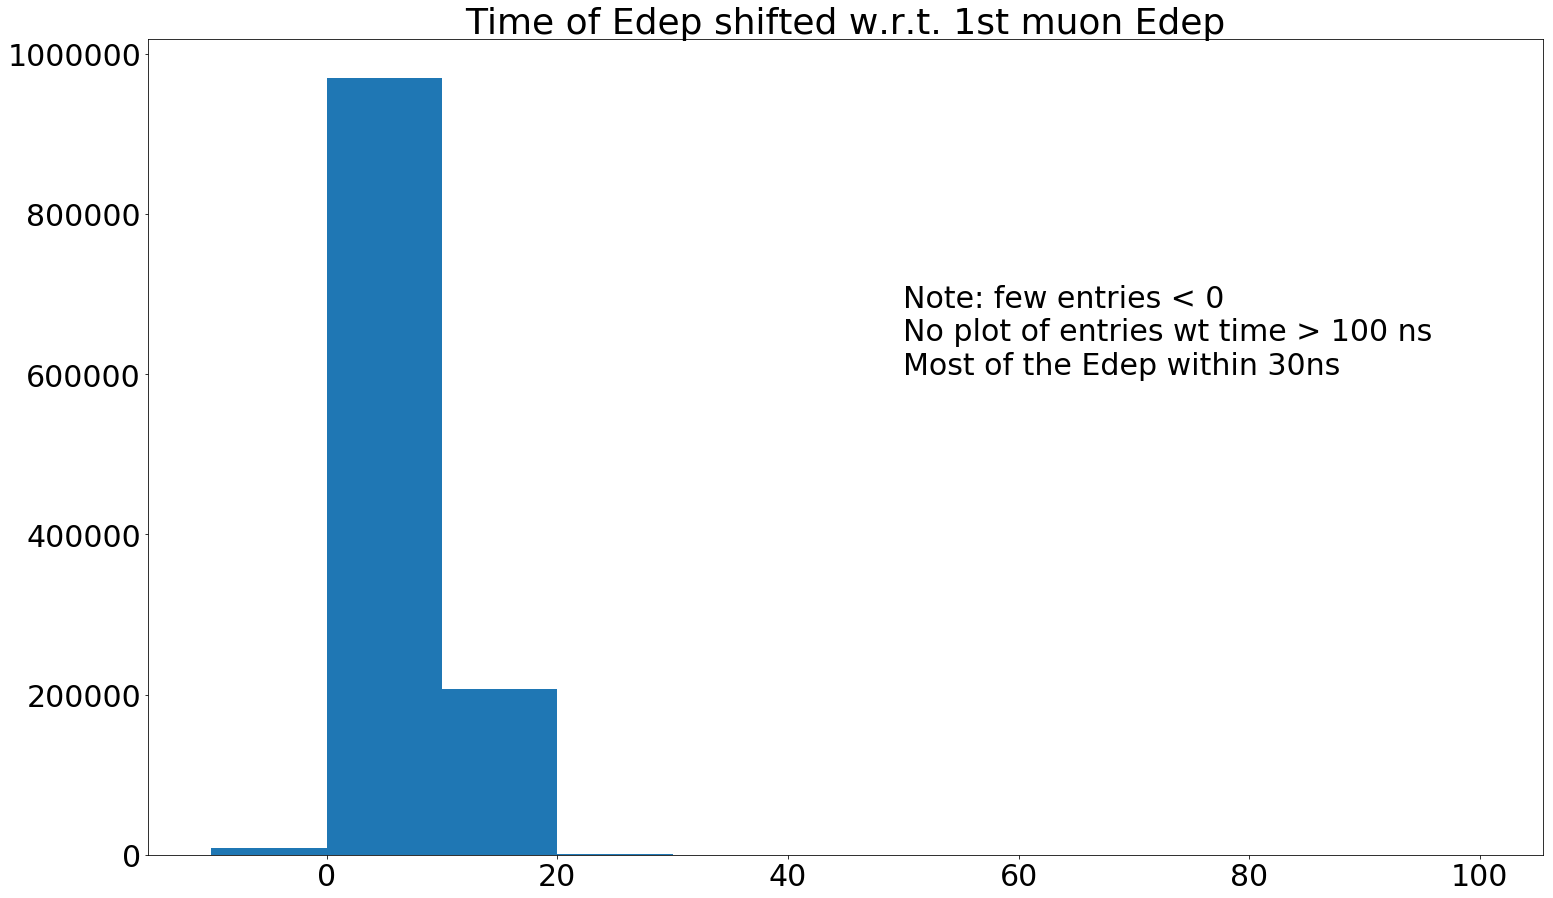

In [4]:
note =  "Note: few entries < 0\n" \
        "No plot of entries wt time > 100 ns\n" \
        "Most of the Edep within 30ns"
plt.hist(p_selection.time, bins=[-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title("Time of Edep shifted w.r.t. 1st muon Edep")
plt.text(50, 600000, note)
plt.show()

In [5]:
t_p_selection = p_selection[p_selection.time < 30].sort_values("time") # discard 2601 entries
t_p_selection


,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID,time_m
1121243,11,6775,74.097200,0.0000,-3.1295,285.9470,-1864.500,27.1461,0.680862,0.632016,0.370111,9902,6805,compt,0,30.3350
1121244,11,6776,165.711000,0.0000,-3.0619,160.5530,-1860.550,53.9324,-0.987219,0.158740,-0.014141,9902,6796,compt,0,30.3350
1121245,11,6776,108.440000,0.0000,-2.9551,170.0660,-1836.670,73.1940,0.648289,0.181145,0.739532,9902,6797,compt,0,30.3350
1121246,11,6776,68.792600,0.0000,-2.7924,144.0950,-1796.730,62.4463,-0.026388,0.786755,-0.616701,9902,6798,compt,0,30.3350
1121247,22,6343,3.206300,0.0000,-2.6047,135.4810,-1845.170,-14.8498,-0.955896,0.122870,-0.266768,9902,6775,annihil,0,30.3350
1121248,11,6775,139.361000,0.0000,-2.6043,135.4160,-1845.160,-14.8215,-0.909020,0.122703,0.398280,9902,6806,phot,0,30.3350
1045211,11,889,992.095000,3318.2900,-2.5525,-548.2100,-1476.800,1907.1000,0.046928,0.495302,-0.867452,6945,1469,compt,0,26.4532
1093527,11,3683,253.135000,912.1450,-2.5429,-1803.8100,-364.363,-418.3340,0.713178,0.423157,-0.558852,4540,3710,compt,0,28.0780
1093528,11,3710,312.810000,68.0214,-2.5415,-1803.8100,-364.012,-418.2980,0.858458,-0.156065,0.488563,4540,3715,eIoni,0,28.0780
1093529,11,3710,68.021400,0.0000,-2.5413,-1803.7900,-364.015,-418.2870,0.858458,-0.156065,0.488563,4540,3715,eIoni,0,28.0780


### Create the first image
As proof of concept, we report the first image.

Max Energy deposited: 23509.024989999998
count    775235.000000
mean        436.769140
std         679.386105
min           0.000287
25%          37.275000
50%         185.085000
75%         585.758000
max       23509.024990
Name: energydeposition, dtype: float64


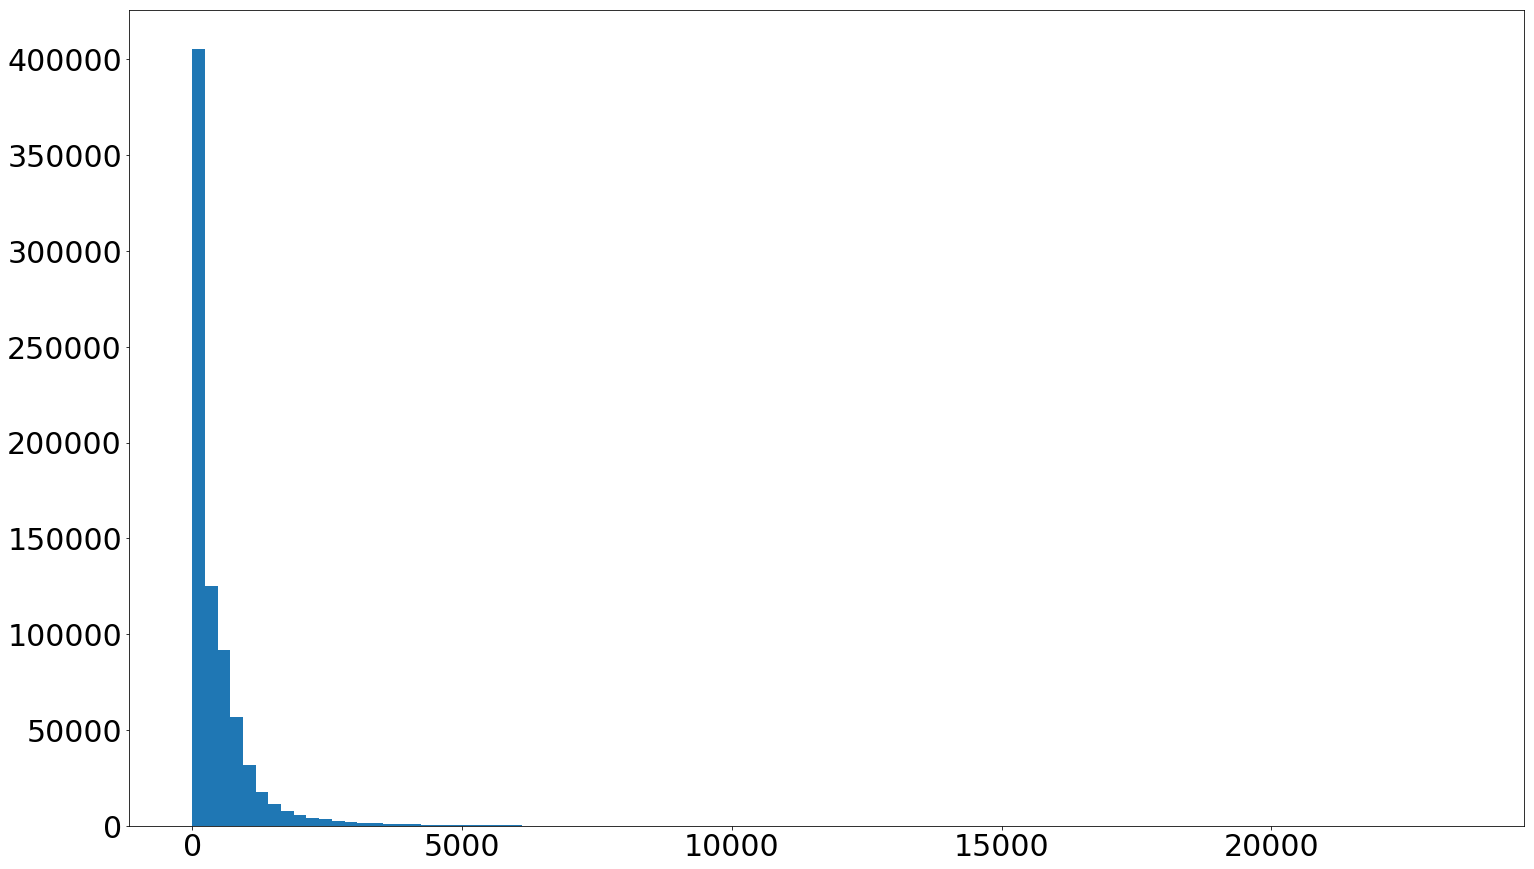

,eventnumber,x,y,energydeposition
148491,1839,-83,-343,23509.02499


In [6]:
bin_space = t_p_selection
bin_space.x = bin_space.x.astype(int)
bin_space.y = bin_space.y.astype(int)

binned = bin_space.groupby(["eventnumber", "x", "y"]).energydeposition.sum().reset_index()
print("Max Energy deposited: {}".format(binned.energydeposition.max()))
print(binned.energydeposition.describe())

plt.hist(binned.energydeposition, 100)
plt.show()
binned.head()

binned[binned.energydeposition == binned.energydeposition.max()]

### Observation:
There is the event `1839` that present a very high-energy deposition in the same (x,y)-coordinate (~23MeV). The reason is that the muon is *almost* vertical, then projecting over (x,y) coordinates accomulate all the energy deposition over the z-axis in that space.

In fact, looking at the description of the x,y,z coordinates in this event, we note that x varies in `[-585, -66]` and y varies in `[-349, -160]`.

In [11]:
df[(df.eventnumber==1839) & (df.PID==13)][["x", "y", "z"]].describe()

,x,y,z
count,148.000000,148.000000,148.000000
mean,-322.534239,-256.639041,-27.616082
std,159.155858,57.867133,1194.809936
min,-585.901000,-349.705000,-1950.000000
25%,-459.130500,-299.003000,-902.138000
50%,-300.521000,-264.676000,-192.811500
75%,-206.016250,-206.986000,997.785250
max,-66.502300,-160.823000,1949.380000


## Ideas:
1. to mitigate this phenomena, we could clip the maximum energy that is possible to deposit in a single point in the x,y space.
1. writing all events in matrixes or images is too time and space consuming. It is better to keep the data in dataframe and eventually create the images later.

In [37]:
from PIL import Image
import math
import time

print(binned.columns)

print("[Info] Number of events: {}".format(t_p_selection.eventnumber.nunique()))
print_info_interval = 10
init = time.time()
for i, event_id in enumerate(t_p_selection.eventnumber.unique()):
    if i > 10:
        break
    if i % print_info_interval == 0:
        interval = time.time() - init
        print("[Info]\t{:.3f}sec\titeration {}:\tsaving event {}".format(interval, i, event_id))
    event = binned[binned.eventnumber==event_id][["energydeposition", "x", "y"]]

    bin_size = 50
    half_size = 2000
    event.x = (event.x + half_size) // bin_size
    event.y = (event.y + half_size) // bin_size
    event = event.groupby(["x", "y"]).energydeposition.sum().reset_index()

    width = height = half_size * 2    # box centered in (0,0,0), we don't consider thickness to have a safe margin
    matrix = np.zeros((width, height))
    for _, row in event.iterrows():
        matrix[int(row.y), int(row.x)] += row.energydeposition
        
    # Scale matrix in 0-255
    max_edep = binned.energydeposition.max()    # 23509.02499 keV
    max_edep = event.energydeposition.max()
    matrix = np.uint8(matrix / max_edep * 255)
    img = Image.fromarray(matrix).resize((320,320))
    img.save("out/event_{}_bin_{}.png".format(event_id, bin_size))
    print("{} nzero values".format(matrix[matrix>0].shape[0]))
    
    # DOESNT WORK WHY????

Index(['eventnumber', 'x', 'y', 'energydeposition'], dtype='object')
[Info] Number of events: 805
[Info]	0.006sec	iteration 0:	saving event 9902
71 nzero values
8 nzero values
15 nzero values
40 nzero values
31 nzero values
45 nzero values
81 nzero values
61 nzero values
59 nzero values
20 nzero values
[Info]	1.449sec	iteration 10:	saving event 4905
12 nzero values
